In [1]:
# expand cells to the 95% of the display width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 95% !important; }</style>"))

# Tutorial: Automatic rule-based modeling of the *Escherichia coli* lactose metabolism, including protein-protein interactions and regulation of gene expression employing *Atlas*

Authors: Rodrigo Santibáñez[1,2], Daniel Garrido[2], and Alberto Martín[1]

Date: August 2020

Affiliations:
1. Centro de Genómica y Bioinformática, Facultad de Ciencias, Universidad Mayor, Santiago, 8580745, Chile.
2. Department of Chemical and Bioprocess Engineering, School of Engineering, Pontificia Universidad Católica de Chile, Santiago, 7820436, Chile

Notes: This tutorial was created for the manuscript "*Atlas*: Automatic modeling of regulation of bacterial gene expression and metabolism using rule-based languages", first submitted for peer-review to Bioinformatics on May, 2020.

## Prerequisites

0. The tutorial was prepared and executed on Ubuntu 20.04, PathwayTools version 24, and docker engine version 19.03.8.<br/><br/>

1. PathwayTools must be installed and running to obtain data from the EcoCyc database. Please, run ```pathway-tools -lisp -python-local-only``` before to obtain any data.<br/>
   (Optional) The PathwayTools software could be executed in the background, with help of ```nohup pathway-tools -lisp -python-local-only > /dev/null 2> /dev/null &```.<br/>
   Please follow instructions at http://pathwaytools.org/ to obtain a licensed copy of the software from https://biocyc.org/download-bundle.shtml. However, data could be manually formatted using a text-based editor or a spreadsheet software.
   
   Note: If you ran into the ```pathway-tools/aic-export/pathway-tools/ptools/22.5/exe/aclssl.so: undefined symbol: CRYPTO_set_locking_callback``` error, please follow instructions here: https://github.com/glucksfall/atlas/tree/master/PTools. Instructions will guide you to install a docker image that is able to run pathway tools, but does not include it, so you still need to obtain the software with a valid license.<br/><br/>
   
2. (Highly recommended) Install Docker. Please follow instructions for a supported Operating System https://docs.docker.com/engine/install/:<br/>
   On Ubuntu, install it with ```apt-get install docker.io```.<br/>
   On Win10, install Docker Desktop with WSL2 support https://docs.docker.com/docker-for-windows/wsl/.<br/>
   On MacOS, install Docker Desktop https://docs.docker.com/docker-for-mac/install/.<br/><br/>
   The Docker ```networkbiolab/pleiades```installs the python packages, the jupyter server, and the stochastic simulators.<br/><br/>

3. (Recommended) Jupyter notebook. We recommend the use of Anaconda3 https://www.anaconda.com/products/individual because of the easier installation of the stochastic simulators from https://anaconda.org/alubbock.<br/><br/>

4. (Optional) A stochastic simulator, supported by the pySB python package ([BNG2](https://github.com/RuleWorld/bionetgen), [NFsim](https://github.com/ruleworld/nfsim/tree/9178d44455f6e27a81f398074eeaafb2a1a4b4bd), [KaSim](https://github.com/Kappa-Dev/KappaTools) or [Stochkit](https://github.com/StochSS/StochKit)). pySB requires BNG2 to simulate models with NFsim.<br/><br/>

5. (Optional) Cytoscape to visualize metabolic networks and others.

## Preamble: load *Atlas*

In [2]:
# testing source code
import sys
sys.path.append("..") # If installed from GitHub and this notebooks is executed from the tutorial directory.

import atlas_rbm.atlas as atlas
import atlas_rbm.utils as utils
import atlas_rbm.export as export
import atlas_rbm.simulation as simulation

## Modeling transcription and translation

Here, we will model a representation for transcription and translation in addition to the activity of transcription factors. We employed the Kappa BioBrick Framework (KBF, https://core.ac.uk/download/pdf/82069591.pdf) and automated the modeling of rules describing bacterial transcription and translation. Especially in the case of mRNA, the synthesis and degradation of any mRNA is affected by the genome architecture. The transcription from the lactose operon is initiated at four promoters and terminated by two Rho-independent terminators. Moreover, we modeled an internal promoter that drives transcription from the lacYA operon, although its importance *in vivo* is not clear.

The following image (https://ecocyc.org/gene?orgid=ECOLI&id=EG10527#tab=TU) shows the organization of the three genes and the many promoters and terminators of the *Escherichia coli* lactose operons.

<img src="lactose-operon.png" alt="drawing"/>

In [3]:
%time model1 = atlas.construct_model_from_genome_graph('network-lac-operon-arq.tsv')
model1

CPU times: user 719 ms, sys: 52.6 ms, total: 771 ms
Wall time: 769 ms


<Model 'atlas_rbm.construct_model_from_genome_graph' (monomers: 4, rules: 29, parameters: 51, expressions: 0, compartments: 0) at 0x7fb9301b9820>

In [4]:
model1 = atlas.modify_rules(
    model1, 
    oldString = "prot(name='lacY', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=None)",
    newString = "prot(name='lacY', loc='imem', dna=None, met=None, prot=None, rna=None, up=None, dw=None)",
    names = ['sr_lacY_rbs'])

**Note**: *Atlas* creates rules for the synthesis of cytoplasmic proteins.

A model of the lactose metabolism is completed with a representation of transcriptional control. To model gene regulation, we extended the interaction network with the LacI-allolactose and LacI-DNA complexes. In the case of LacI, each dimer binds in tandem to one operator sequence, and two dimers could dimerize, forming a DNA loop that impedes the binding of RNAP-$\sigma$ to promoters or initiates transcription. To inactivate LacI, free proteins bind allolactose that seems to impede the binding of LacI-allolactose complexes to DNA binding sites:

Because *Atlas* enumerates the physical interactions, we must concatenate the networks prior its modeling:

In [5]:
import pandas
%time network = pandas.concat([utils.read_network('network-lac-ProtProt.tsv'), utils.read_network('network-lac-TFs+DNA.tsv'), utils.read_network('network-lac-ProtMet.tsv')])
network

CPU times: user 7.36 ms, sys: 3.82 ms, total: 11.2 ms
Wall time: 9.69 ms


,SOURCE,TARGET,FWD_RATE,RVS_RATE,LOCATION
0,lacZ,lacZ,1.0,0.0,cytosol
1,"[lacZ,lacZ]","[lacZ,lacZ]",1.0,0.0,cytosol
2,lacA,lacA,1.0,0.0,cytosol
3,lacA,"[lacA,lacA]",1.0,0.0,cytosol
0,"[lacI,lacI]",BS-lacI-422-402,1.0,1.0,cytosol
1,"[lacI,lacI]",BS-lacI-21-1,1.0,1.0,cytosol
2,"[lacI,lacI]",BS-lacI-72-92,1.0,1.0,cytosol
0,"[lacI,lacI]",SMALL-alpha-ALLOLACTOSE,1.0,1.0,cytosol
1,"[lacI,SMALL-alpha-ALLOLACTOSE,lacI]",SMALL-alpha-ALLOLACTOSE,1.0,1.0,cytosol
2,"[lacI,lacI]",SMALL-beta-ALLOLACTOSE,1.0,1.0,cytosol


**Note**: *Atlas* interprets an interaction network as a protein-protein interaction network. To define metabolites, please prefix names with `SMALL-` and DNA binding sites as `BS-` followed by a name and two coordinates.

In [6]:
%time model2 = atlas.construct_model_from_interaction_network(network)
model2

CPU times: user 432 ms, sys: 7.6 ms, total: 439 ms
Wall time: 438 ms


<Model 'atlas_rbm.construct_model_from_interaction_network' (monomers: 3, rules: 11, parameters: 35, expressions: 0, compartments: 0) at 0x7fb8cc57a880>

In [7]:
new_rule = "Rule('PhysicalInteractionRule_02', "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=2) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=None) + "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=None) | "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=4, dw=1) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=3, dw=4), "\
            "fwd_PhysicalInteractionRule_02, rvs_PhysicalInteractionRule_02)"

model2 = atlas.replace_rule(model2, 'PhysicalInteractionRule_02', new_rule)

In [8]:
new_rule = "Rule('PhysicalInteractionRule_04', "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=None) + "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=None) | "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=3, dw=1) % "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=3), "\
            "fwd_PhysicalInteractionRule_04, rvs_PhysicalInteractionRule_04)"

model2 = atlas.replace_rule(model2, 'PhysicalInteractionRule_04', new_rule)

Finally, we build the metabolic network:

In [9]:
%time model3 = atlas.construct_model_from_metabolic_network('network-lac-metabolism-complex-new-parameters.tsv')
model3

CPU times: user 647 ms, sys: 4.3 ms, total: 652 ms
Wall time: 650 ms


<Model 'atlas_rbm.construct_model_from_metabolic_network' (monomers: 2, rules: 18, parameters: 61, expressions: 0, compartments: 0) at 0x7fb930198f10>

In [10]:
model3 = atlas.modify_rules(
    model3, 
    oldString = "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % " \
                "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % " \
                "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % " \
                "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=3, dw=None)",
    
    newString = "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up = ANY, dw = ANY)",
    names = [
        'BETAGALACTOSID_RXN',
        'BETAGALACTOSID_RXN_alpha', 
        'RXN0_5363', 
        'RXN0_5363_beta', 
        'ALLOLACTOSE_DEG_alpha', 
        'ALLOLACTOSE_DEG_beta', 
        'RXN_17726', 
        'RXN0_7219'])

In [11]:
model3 = atlas.modify_rules(
    model3, 
    oldString = "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % " \
                "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % " \
                "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=None)",
    
    newString = "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up = ANY, dw = ANY)",
    names = ['GALACTOACETYLTRAN_RXN_galactose'])

In [12]:
%time combined = atlas.combine_models([model1, model2, model3])
combined

CPU times: user 2.78 s, sys: 18.4 ms, total: 2.8 s
Wall time: 2.8 s


<Model 'atlas_rbm.atlas' (monomers: 5, rules: 58, parameters: 138, expressions: 0, compartments: 0) at 0x7fb8cc47d5b0>

In [18]:
# initial condition
# for metabolites (set again doesn't hurt)
simulation.set_initial.met(combined, 'beta_lactose', 'per', 100)
simulation.set_initial.met(combined, 'PROTON', 'per', 100) # required for lactose transport
simulation.set_initial.met(combined, 'WATER', 'cyt', 100) # required for lactose hydrolysis

# for proteins. We set to zero to simulate gene expression as a requisite for metabolic activity
simulation.set_initial.prot(combined, 'lacY', 'imem', 0)
simulation.set_initial.prot(combined, 'lacZ', 'cyt', 0)
simulation.set_initial.prot(combined, 'lacA', 'cyt', 0)

# for complexes. We set to zero to simulate complex assembly as a requisite for metabolic activity
simulation.set_initial.cplx(combined, 'lacAx3', 'cyt', 0) # the codename for complexes is the monomer names times the stoichiometry
simulation.set_initial.cplx(combined, 'lacZx4', 'cyt', 0)
simulation.set_initial.cplx(combined, 'RNAP_CPLX', 'cyt', 1)
simulation.set_initial.cplx(combined, 'RIBOSOME_CPLX', 'cyt', 1)

# and DNA
simulation.set_initial.dna(combined, 'lacZlacYlacA', 1)

# simulation
bng = '/opt/git-repositories/bionetgen.RuleWorld/bng2/'
kasim = '/opt/git-repositories/KaSim4.Kappa-Dev/'

# %time data1 = simulation.scipy(combined, start = 0, finish = 10, points = 500)
%time data2 = simulation.kasim(combined, start = 0, finish = 500, points = 500, n_runs = 100, path = kasim)

CPU times: user 3.57 s, sys: 833 ms, total: 4.4 s
Wall time: 42.8 s


In [15]:
import seaborn
import matplotlib.pyplot as plt

for key in [
#     'figure.titlesize',
    'font.size',
#     'legend.fontsize',
#     'legend.title_fontsize',
    'font.size', 
#     'xtick.labelsize',
    'xtick.major.size',
    'xtick.minor.size',
#     'ytick.labelsize',
    'ytick.major.size',
    'ytick.minor.size']:
    plt.rcParams[key] = plt.rcParams[key] * 1.1

palette = seaborn.color_palette('colorblind')

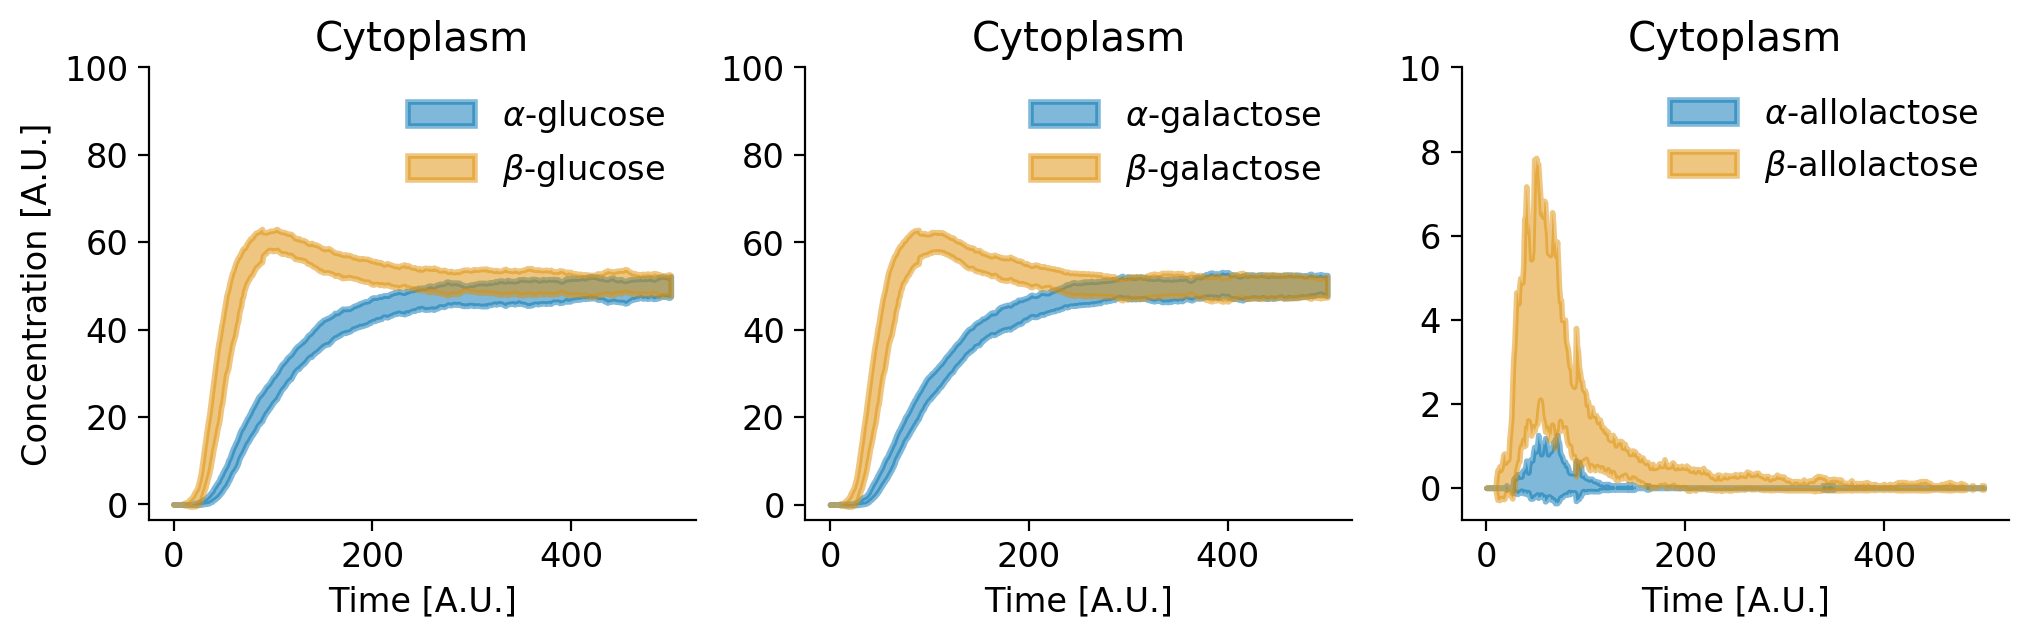

In [22]:
kind = 'fill_between'
fig, ax = plt.subplots(1, 3, figsize = (4*3, 3*1), dpi = 200)

# first plot, lactose concentration
# simulation.plot.metabolite(data1, 'alpha-glucose', 'cyt', ax = ax[0], plt_kws = {'label' : r'$\alpha$-glucose'})
# simulation.plot.metabolite(data1, 'beta-glucose', 'cyt', ax = ax[0], plt_kws = {'label' : r'$\beta$-glucose'})

simulation.plot.metabolite(
    data2, 'alpha-glucose', 'cyt', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5, 'label' : r'$\alpha$-glucose'})

simulation.plot.metabolite(
    data2, 'beta-glucose', 'cyt', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5, 'label' : r'$\beta$-glucose'})

# second plot, galactose concentration
# simulation.plot.metabolite(data1, 'alpha-GALACTOSE', 'cyt', ax = ax[1], plt_kws = {'label' : r'$\alpha$-galactose'})
# simulation.plot.metabolite(data1, 'beta-GALACTOSE', 'cyt', ax = ax[1], plt_kws = {'label' : r'$\beta$-galactose'})

simulation.plot.metabolite(
    data2, 'alpha-GALACTOSE', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5, 'label' : r'$\alpha$-galactose'})

simulation.plot.metabolite(
    data2, 'beta-GALACTOSE', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5, 'label' : r'$\beta$-galactose'})

# third plot, allolactose concentration
# simulation.plot.metabolite(data1, 'alpha-ALLOLACTOSE', 'cyt', ax = ax[2], plt_kws = {'label' : r'$\alpha$-allolactose'})
# simulation.plot.metabolite(data1, 'beta-ALLOLACTOSE', 'cyt', ax = ax[2], plt_kws = {'label' : r'$\beta$-allolactose'})

simulation.plot.metabolite(
    data2, 'alpha-ALLOLACTOSE', 'cyt', ax = ax[2], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5, 'label' : r'$\alpha$-allolactose'})

simulation.plot.metabolite(
    data2, 'beta-ALLOLACTOSE', 'cyt', ax = ax[2], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5, 'label' : r'$\beta$-allolactose'})

ax[0].set_xlabel('Time [A.U.]')
ax[0].set_ylabel('Concentration [A.U.]')
ax[0].set_title('Cytoplasm')
ax[0].set_ylim(top = 100)

ax[1].set_xlabel('Time [A.U.]')
ax[1].set_title('Cytoplasm')
ax[1].set_ylim(top = 100)

ax[2].set_xlabel('Time [A.U.]')
ax[2].set_title('Cytoplasm')
ax[2].set_ylim(top = 10)

ax[0].legend(frameon = False)
ax[1].legend(frameon = False)
ax[2].legend(frameon = False)

seaborn.despine()
plt.show()